# Ants Bees VGG16 による解析

# Fitting 

# TypeBによるTrainingクラスの作成

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pillow==6.2.1

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9 MB 683 bytes/s 
     |████████████████████████████████| 8.8 MB 30.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.
     |████████████████████████████████| 2.1 MB 13.5 MB/s 
  Attempting uninstall: pillow


In [ ]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data'
root_dir= '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data'

In [ ]:
'''
3. 前処理前後の画像を確認する
'''
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data
from pathlib import Path


In [ ]:
'''
2. 前処理クラスの定義
'''
class ImageTransform():
    '''画像の前処理クラス。訓練時、検証時で異なる動作をする。

    Attributes:
      data_transform(dic):
        train: 訓練用のトランスフォーマーオブジェクト
        val  : 検証用のトランスフォーマーオブジェクト
    '''

    def __init__(self, resize, mean, std):
        '''トランスフォーマーオブジェクトを生成する。

        Parameters:
        resize(int): リサイズ先の画像の大きさ
        mean(tuple): (R, G, B)各色チャネルの平均値
        std        : (R, G, B)各色チャネルの標準偏差
        '''
        # dicに訓練用、検証用のトランスフォーマーを生成して格納
        self.data_transform = {
            'train': transforms.Compose([
                # ランダムにトリミングする
                transforms.RandomResizedCrop(
                    resize, # トリミング後の出力サイズ
                    scale=(0.5, 1.0)),  # スケールの変動幅
                transforms.RandomHorizontalFlip(p = 0.5),  # 0.5の確率で左右反転
                transforms.RandomRotation(15),  # 15度の範囲でランダムに回転
                transforms.ToTensor(),          # Tensorオブジェクトに変換
                transforms.Normalize(mean, std) # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),      # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeでトリミング
                transforms.ToTensor(),          # テンソルに変換
                transforms.Normalize(mean, std) # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        '''オブジェクト名でコールバックされる
        Parameters:
          img: 画像
          phase(str): 'train'または'val' 前処理のモード
        '''
        return self.data_transform[phase](img) # phaseはdictのキー


### 前処理前後の画像を確認する


In [ ]:
tt='hymenoptera_data/'+'train'+'/bees/2405441001_b06c36fa72.jpg'
image_file_path = os.path.join(data_dir,tt)
print(image_file_path)

/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg


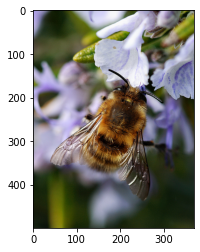

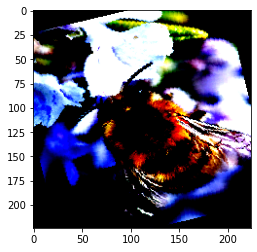

In [ ]:

%matplotlib inline

# サンプル画像を1枚読み込む
image_file_path = os.path.join(data_dir,'hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg')
img = Image.open(image_file_path)   # (高さ, 幅, RGB)

# 元の画像の表示
plt.imshow(img)
plt.show()

# 画像の前処理と処理済み画像の表示
# モデルの入力サイズ(タテ・ヨコ)
SIZE = 224
# 標準化する際の各RGBの平均値
MEAN = (0.485, 0.456, 0.406) # ImageNetデータセットの平均値を使用
# 標準化する際の各RGBの標準偏差
STD = (0.229, 0.224, 0.225)  # ImageNetデータセットの標準偏差を使用

# トランスフォーマーオブジェクトを生成
transform = ImageTransform(SIZE, MEAN, STD)
# 訓練モードの前処理を適用、torch.Size([3, 224, 224])
img_transformed = transform(img, phase="train")

# (色、高さ、幅)を (高さ、幅、色)に変換
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
# ピクセル値を0～1の範囲に制限して表示
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

#(1) DataSet の作成

### train_list, val_list の作成

In [ ]:
import glob
import pprint
def make_datapath_list(phase='train'):
    '''
    データのファイルパスを格納したリストを作成する。

    Parameters:
      phase(str): 'train'または'val'

    Returns:
      path_list(list): 画像データのパスを格納したリスト
    '''
    # 画像ファイルのルートディレクトリ
    # 画像ファイルパスのフォーマットを作成
    # rootpath +
    #   train/ants/*.jpg
    #   train/bees/*.jpg
    #   val/ants/*.jpg
    #   val/bees/*.jpg
    tt= phase +'/**/*.jpg'
    target_path = os.path.join(root_dir,tt)
    # ファイルパスを格納するリスト
    path_list = []  # ここに格納する

    # glob()でファイルパスを取得してリストに追加
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

# ファイルパスのリストを生成
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

print(train_list)

# 訓練データのファイルパスの前後5要素ずつ出力
print('train')
pprint.pprint(train_list[:5])
pprint.pprint(train_list[-6:-1])
# 検証データのファイルパスの前後5要素ずつ出力
print('val')
pprint.pprint(val_list[:5])
pprint.pprint(val_list[-6:-1])

['/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/0013035.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg', '/content/gdrive/My Drive/Colab Notebooks/AntsBees/data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg', '/cont

In [ ]:
p=Path(train_list[5])
print(p.parts[-2])

p2=Path(val_list[-4])
print(p2.parts[-2])

ants
bees


In [ ]:

class MakeDataset(data.Dataset):
    '''
    アリとハチの画像のDatasetクラス
    PyTorchのDatasetクラスを継承

    Attributes:
      file_list(list): 画像のパスを格納したリスト
      transform(object): 前処理クラスのインスタンス
      phase(str): 'train'または'val'
    Returns:
      img_transformed: 前処理後の画像データ
      label(int): 正解ラベル
    '''
    def __init__(self, file_list, transform=None, phase='train'):
        '''インスタンス変数の初期化
        '''
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase          # 'train'または'val'

    def __len__(self):
        '''len(obj)で実行されたときにコールされる関数
        画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''Datasetクラスの__getitem__()をオーバーライド
           obj[i]のようにインデックスで指定されたときにコールバックされる

           Parameters:
             index(int): データのインデックス
           Returns:

          前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # ファイルパスのリストからindex番目の画像をロード
        img_path = self.file_list[index]
        # ファイルを開く -> (高さ, 幅, RGB)
        img = Image.open(img_path)

        # 画像を前処理  -> torch.Size([3, 224, 224])
        img_transformed = self.transform(
            img, self.phase)
        
        p=Path(img_path)
        label=p.parts[-2]
        # 正解ラベルをファイル名から切り出す
        #if self.phase == 'train':
            # 訓練データはファイルパスの31文字から34文字が'ants'または'bees'
        #    p=Path(img_path)
        #    label=p.parts[-2]
        #elif self.phase == 'val':
        #    # 検証データはファイルパスの29文字から32文字が'ants'または'bees'
        #    label=p.parts[-2]

        # 正解ラベルの文字列を数値に変更する
        if label == 'ants':
            label = 0 # アリは0
        elif label == 'bees':
            label = 1 # ハチは1

        return img_transformed, label

### train_dataset, val_dataset の作成

In [ ]:
'''
6. データローダーの生成
'''
import torch

# ミニバッチのサイズを指定
batch_size = 32
# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD

# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeDataset(
    file_list=train_list, # 訓練データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='train')
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeDataset(
    file_list=val_list, # 検証データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='val')


#(2) DataLoader の作成

In [ ]:
'''
6. データローダーの生成
'''
import torch

# ミニバッチのサイズを指定
batch_size = 10
# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD

# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeDataset(
    file_list=train_list, # 訓練データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='train')
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeDataset(
    file_list=val_list, # 検証データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='val')

# 訓練用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
train_dl = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
# 検証用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
val_dl = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
print(train_dl.batch_size)

10


#(3) DataLoaderの辞書の作成

In [ ]:
# データローダーをdictにまとめる
dataloaders_dict = {'train': train_dl, 'val': val_dl}

In [ ]:
print(len(dataloaders_dict["train"].dataset))
print(len(dataloaders_dict["val"].dataset))
print(len(dataloaders_dict["train"]))
print(len(dataloaders_dict["val"]))

243
153
25
16


### 動作確認

In [ ]:
batch_iterator = iter(dataloaders_dict['train'])
images, target = next(batch_iterator)

print(images.size())
print(target)

a=images.size()
print(type(a))

print(images.shape)
print(type(images.shape))

b=images.shape
print(type(b))

torch.Size([10, 3, 224, 224])
tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1])
<class 'torch.Size'>
torch.Size([10, 3, 224, 224])
<class 'torch.Size'>
<class 'torch.Size'>


#(4) モデルの作成

In [ ]:
'''
7. 学習済みのVGG16モデルをロード
'''
from torchvision import models
import torch.nn as nn

# ImageNetで事前トレーニングされたVGG16モデルを取得
model = models.vgg16(pretrained=True)

# VGG16の出力層のユニット数を2にする
model.classifier[6] = nn.Linear(
    in_features=4096, # 入力サイズはデフォルトの4096
    out_features=2)   # 出力はデフォルトの1000から2に変更

# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print(device)

cuda


### 学習可能の層を指定

In [ ]:
'''
8. VGG16で学習可能にする層を設定
'''
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 出力層の重みとバイアスを更新可として登録
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

# 出力層以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True # 勾配計算を行う
        params_to_update.append(param) # パラメーター値を更新
        print(name) # 更新するパラメーター名を出力
    else:
        param.requires_grad = False # 出力層以外は勾配計算なし

classifier.6.weight
classifier.6.bias


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#（5）損失関数の定義
# (6)Optimizerの定義

In [ ]:
'''
9. 損失関数とオプティマイザーを生成
'''
import torch.optim as optim

# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザー
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

### 動作確認

In [ ]:
import pickle
from sklearn.metrics import accuracy_score
from tqdm import tqdm

for batch_ndx, batch_tup in enumerate(tqdm(dataloaders_dict['train'])):
  input_t, label_t = batch_tup
  print(len(batch_tup))
  print(type(batch_tup))
  print(batch_tup[0].shape)
  print(batch_tup[1].shape)
  print(input_t.shape)
  if batch_ndx>3:
    break

  4%|▍         | 1/25 [00:02<00:49,  2.06s/it]

2
<class 'list'>
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])


  8%|▊         | 2/25 [00:04<00:55,  2.42s/it]

2
<class 'list'>
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])


 12%|█▏        | 3/25 [00:06<00:51,  2.32s/it]

2
<class 'list'>
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])


 16%|█▌        | 4/25 [00:08<00:41,  1.98s/it]

2
<class 'list'>
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])


 16%|█▌        | 4/25 [00:10<00:53,  2.57s/it]

2
<class 'list'>
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])


In [ ]:


batch_iterator = iter(train_dl)
batch_tup = next(batch_iterator)

input_t, label_t = batch_tup

input_g=input_t.to(device)
label_g=label_t.to(device)
model = model.to(device)

outputs = model(input_g)

print(outputs)
print(outputs.argmax(dim=-1).tolist())
print(target.tolist())
from sklearn.metrics import accuracy_score
print(accuracy_score(target.tolist(),outputs.argmax(dim=-1).tolist()))

tensor([[-0.3937,  0.4581],
        [-1.1026, -0.2806],
        [-0.4535,  0.0050],
        [-0.7000,  1.0222],
        [-1.1127,  0.7250],
        [-1.0811,  0.2201],
        [-1.9286,  0.3290],
        [-0.8454, -0.2547],
        [-0.2569,  0.4197],
        [ 0.0432,  0.1530]], device='cuda:0', grad_fn=<AddmmBackward>)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
0.5


In [ ]:
softmax = nn.Softmax(dim=1)
prob_g=softmax(outputs)
print(prob_g[:,1])

tensor([0.7009, 0.6947, 0.6127, 0.8484, 0.8627, 0.7860, 0.9053, 0.6435, 0.6630,
        0.5274], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
loss_func = nn.CrossEntropyLoss(reduction='none')
loss_g = loss_func(outputs,label_g)
print(loss_g)

tensor([1.2071, 0.3643, 0.4899, 0.1644, 0.1477, 0.2408, 0.0995, 0.4408, 1.0876,
        0.7496], device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
print(outputs)

tensor([[-0.3937,  0.4581],
        [-1.1026, -0.2806],
        [-0.4535,  0.0050],
        [-0.7000,  1.0222],
        [-1.1127,  0.7250],
        [-1.0811,  0.2201],
        [-1.9286,  0.3290],
        [-0.8454, -0.2547],
        [-0.2569,  0.4197],
        [ 0.0432,  0.1530]], device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:
print(target)

tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1])


#(8) 学習の実施

In [ ]:
print(len(train_dl))
print(len(train_dl.dataset))

25
243


In [ ]:
for batch_ndx, batch_tup in enumerate(train_dl):
  input_t, label_t = batch_tup
  print(label_t.shape)
  print(input_t.shape)


torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([10])
torch.Size([10, 3, 224, 224])
torch.Size([1

In [ ]:
metrics_g= torch.zeros(3,len(train_dl.dataset),device='cuda',)
print(metrics_g.shape)

torch.Size([3, 243])


In [ ]:
metrics_g= torch.zeros(3,len(train_dl.dataset),device='cuda',)


for batch_ndx, batch_tup in enumerate(train_dl):
  input_t, label_t = batch_tup

  input_g = input_t.to('cuda')
  label_g = label_t.to('cuda')
  model = model.to('cuda')

  outputs  = model(input_g)

  softmax = nn.Softmax(dim=1)
  prob_g= softmax(outputs)
  #print(prob_g[:,1])

  loss_func = nn.CrossEntropyLoss(reduction='none')
  loss_g = loss_func(outputs,label_g)

  start_ndx = batch_ndx * batch_size
  end_ndx = start_ndx + label_t.size()[0]
  print('start_ndx,end_ndx',start_ndx,end_ndx,label_g.shape[0],prob_g.shape[0],loss_g.shape[0])


  metrics_g[0, start_ndx:end_ndx] = label_g
  metrics_g[1, start_ndx:end_ndx] = prob_g[:,1]
  metrics_g[2, start_ndx:end_ndx] = loss_g

start_ndx,end_ndx 0 10 10 10 10
start_ndx,end_ndx 10 20 10 10 10
start_ndx,end_ndx 20 30 10 10 10
start_ndx,end_ndx 30 40 10 10 10
start_ndx,end_ndx 40 50 10 10 10
start_ndx,end_ndx 50 60 10 10 10
start_ndx,end_ndx 60 70 10 10 10
start_ndx,end_ndx 70 80 10 10 10
start_ndx,end_ndx 80 90 10 10 10
start_ndx,end_ndx 90 100 10 10 10
start_ndx,end_ndx 100 110 10 10 10
start_ndx,end_ndx 110 120 10 10 10
start_ndx,end_ndx 120 130 10 10 10
start_ndx,end_ndx 130 140 10 10 10
start_ndx,end_ndx 140 150 10 10 10
start_ndx,end_ndx 150 160 10 10 10
start_ndx,end_ndx 160 170 10 10 10
start_ndx,end_ndx 170 180 10 10 10
start_ndx,end_ndx 180 190 10 10 10
start_ndx,end_ndx 190 200 10 10 10
start_ndx,end_ndx 200 210 10 10 10
start_ndx,end_ndx 210 220 10 10 10
start_ndx,end_ndx 220 230 10 10 10
start_ndx,end_ndx 230 240 10 10 10
start_ndx,end_ndx 240 243 3 3 3


In [ ]:
print(metrics_g.shape)

torch.Size([3, 243])


In [ ]:
print(len(val_dl))
print(len(val_dl.dataset))

16
153


In [ ]:
import pickle
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

import torch.optim as optim


# 損失関数
criterion = nn.CrossEntropyLoss()

# オプティマイザー
optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.99)


# 損失と精度の履歴を保存するためのdictオブジェクト
history = {'train_loss':[],'train_accuracy':[], 'val_loss':[], 'val_accuracy':[]}

METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_LOSS_NDX=2
METRICS_SIZE = 3

trnMetrics_g = torch.zeros(
    METRICS_SIZE,
    len(train_dl.dataset),
    device='cuda',)

valMetrics_g = torch.zeros(
    METRICS_SIZE,
    len(val_dl.dataset),
    device='cuda',)
          

class training():
  def __init__(self):
    self.model=model 
    self.softmax=nn.Softmax(dim=1)
    self.optimizer=optimizer
    self.num_epochs=5
    self.batch_size=10
    self.use_cuda = True
    self.device = torch.device("cuda" if self.use_cuda else "cpu")
    self.totalTrainingSamples_count = 0
    self.network_dir = '/content/gdrive/MyDrive/Colab Notebooks/AntsBees/network'
    self.result_dir = '/content/gdrive/MyDrive/Colab Notebooks/AntsBees/result'

  def main(self):
    
    for epoch_ndx in range(self.num_epochs):
      self.doTraining(epoch_ndx, train_dl)
      print('epoch_{}.doTraining_done'.format(epoch_ndx))

      self.doValidation(epoch_ndx, val_dl)
      print('epoch_{}.doValidation_done'.format(epoch_ndx))

      #self.save_network(self.model, epoch_ndx, self.network_dir)
      print('epoch_{}.network_save_done'.format(epoch_ndx))

      #self.save_files(metrics_dict,epoch_ndx,save_path)
      #print('epoch_{}.network_save_done'.format(epoch_ndx))

      
  def save_network(self,network, epoch_ndx,network_dir):
    save_filename = 'net_%s.pth' % (epoch_ndx)
    save_path = os.path.join(network_dir, save_filename)
    torch.save(network.state_dict(),save_path)

  def save_files(self,metrics_dict,epoch_ndx,save_dir):
    save_filename = 'metrics_dict_%s.pth' % (epoch_ndx)
    save_path = os.path.join(result_dir, save_filename)
    pickle_dump(metrics_dict,save_path)

  def doTraining(self, epoch_ndx, train_dl):
    
    self.model.train()

    for batch_ndx, batch_tup in enumerate(train_dl):
      self.optimizer.zero_grad()

      loss_var = self.computeBatchLoss(
        batch_ndx,
        batch_tup,
        train_dl.batch_size,trnMetrics_g)
    
      loss_var.backward()
      self.optimizer.step()

    return trnMetrics_g.to('cpu')

  def doValidation(self, epoch_ndx, val_dl):
      with torch.no_grad():
        self.model.eval()
      
        for batch_ndx, batch_tup in enumerate(val_dl):
          input_t, label_t = batch_tup
          input_g = input_t.to(self.device)
          label_g = label_t.to(self.device)
          loss_var=self.computeBatchLoss(
              batch_ndx,
              batch_tup,
              val_dl.batch_size,valMetrics_g)
      
      return valMetrics_g.to('cpu')  

  def computeBatchLoss(self, batch_ndx, batch_tup, batch_size,metrics_g):
      input_t, label_t = batch_tup

      input_g = input_t.to(self.device)
      label_g = label_t.to(self.device)

      outputs  = self.model(input_g)

      softmax = nn.Softmax(dim=1)
      prob_g=self.softmax(outputs)
      #print(prob_g[:,1])

      loss_func = nn.CrossEntropyLoss(reduction='none')
      loss_g = loss_func(
            outputs,
            label_g,
        )
      
      start_ndx = batch_ndx * batch_size
      end_ndx = start_ndx + label_t.size()[0]

      metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = label_g
      metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = prob_g[:,1]
      metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = loss_g
      
      return loss_g.mean()




In [ ]:
training().main()

epoch_0.doTraining_done
epoch_0.doValidation_done
epoch_0.network_save_done
epoch_1.doTraining_done
epoch_1.doValidation_done
epoch_1.network_save_done
epoch_2.doTraining_done
epoch_2.doValidation_done
epoch_2.network_save_done
epoch_3.doTraining_done
epoch_3.doValidation_done
epoch_3.network_save_done
epoch_4.doTraining_done
epoch_4.doValidation_done
epoch_4.network_save_done


In [ ]:
print(trnMetrics_g.shape)
print(valMetrics_g.shape)

torch.Size([3, 243])
torch.Size([3, 153])


#END